In [91]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
from matplotlib import colors

import seaborn as sns
import dataframe_image as dfi

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
base_path = Path('invivo_fits')

In [5]:
# Load all the masks
masks = []
for idx in range(5):
    tmpmask = np.atleast_3d(nib.load(f'data/in_vivo/hv10{idx+1}/mask_to_fit.nii.gz').get_fdata())
    masks.append(np.array(tmpmask, dtype=bool))

In [6]:
df_acumulator = []
total_files = len(list(base_path.rglob('molarity/*.nii.gz')))
for idx, path in enumerate(base_path.rglob('molarity/*.nii.gz')):
    metab = path.name[:-7]
    subject = int(path.parent.parent.parent.parent.parent.name[-1:])
    index_str = path.parent.parent.parent.name
    if index_str == 'fit_combined':
        index = 'comb'
    else:
        index = int(index_str[-2:])
    denoising = path.parent.parent.parent.parent.name
    mask = masks[subject - 1]
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[denoising], [metab],[subject], voxels, [index]]
    index = pd.MultiIndex.from_product(iterables, names=["method", "metabolite", "subject", "voxels", "index"])
    df_acumulator.append(pd.Series(data, index=index))
    
#     if idx == 5:
#         break
    if not idx % 500:
        print(f'{idx}/{total_files} done')
    
df_molarity = pd.concat(df_acumulator,join='inner')

0/8910 done
500/8910 done
1000/8910 done
1500/8910 done
2000/8910 done
2500/8910 done
3000/8910 done
3500/8910 done
4000/8910 done
4500/8910 done
5000/8910 done
5500/8910 done
6000/8910 done
6500/8910 done
7000/8910 done
7500/8910 done
8000/8910 done
8500/8910 done


In [7]:
df_molarity_comb = df_molarity.xs('comb',level='index')
df_molarity_comb

df_molarity_single = df_molarity.drop('comb',level='index')
df_molarity_single.replace(0.0, np.nan,inplace=True)
df_molarity_single

method  metabolite  subject  voxels  index
st_g    Cr          4        0       10       21.046726
                             1       10       16.045764
                             2       10       17.706503
                             3       10       18.190147
                             4       10       17.953768
                                                ...    
st_l    NAA         1        191     9        41.207376
                             192     9        48.705566
                             193     9        45.555076
                             194     9        42.175549
                             195     9        32.166873
Length: 1587600, dtype: float64

In [8]:
metab_all_fitted = ['Cr', 'Tau', 'NAAG', 'MM14', 'GSH', 'Gln', 'Asp',
                    'Lac', 'Ins', 'MM12', 'PCr', 'MM17', 'MM09', 'Asc',
                    'MM21', 'Glu', 'GABA', 'Glc', 'Scyllo', 'GPC', 'PCho',
                    'NAA']
metab_all_large = ['Glu+Gln', 'Glc+Tau', 'PCho+GPC', 'NAA+NAAG', 'Ins', 'Cr+PCr']
metab_all_unique = ['Glu+Gln', 'Glc+Tau', 'PCho+GPC', 'MM14', 'GSH',
                    'Asp', 'NAA+NAAG', 'Lac', 'Ins', 'MM12', 'MM17', 'MM09',
                    'Asc', 'MM21', 'GABA', 'Scyllo', 'Cr+PCr']

### Reproducibility as SD of shorter acquisitions

In [9]:
df_repro = df_molarity_single.std(level=["method", "metabolite", "subject", "voxels"])

df_repro_rel = df_repro.divide(df_repro.xs('noisy', level='method').median(level=["metabolite"]))
df_repro_rel = df_repro_rel.reorder_levels([ "metabolite", "method", "subject", "voxels"])

# Remove outliers 
df_repro_rel[df_repro_rel>10] = np.nan

#### Numbers for results

In [10]:
method_order = ['noisy', 'st_g', 'st_l', 'lp', 'lo_g', 'lo_l']
labels = ['Noisy', 'Global ST', 'Local ST', 'LP', 'Global LORA', 'Local LORA']

print('All large metabolites')
for method,label in zip(method_order,labels):
    tmp = df_repro_rel.loc[metab_all_large].xs(method,level='method')
    print(f'{label} = {tmp.median():0.2f}±{tmp.std():0.2f}')

print('\nAll unique metabolites')
for method,label in zip(method_order,labels):
    tmp = df_repro_rel.loc[metab_all_unique].xs(method,level='method')
    print(f'{label} = {tmp.median():0.2f}±{tmp.std():0.2f}')

All large metabolites
Noisy = 1.00±0.59
Global ST = 0.95±0.53
Local ST = 0.94±0.53
LP = 1.03±0.59
Global LORA = 0.90±0.48
Local LORA = 0.86±0.52

All unique metabolites
Noisy = 1.00±0.97
Global ST = 0.87±0.84
Local ST = 0.90±0.95
LP = 1.07±1.15
Global LORA = 0.90±1.05
Local LORA = 0.90±1.09


### Error compared to high SNR

In [11]:
metab_all_interesting = metab_all_large + ['GABA',]
rmse_final = df_molarity_single.subtract(df_molarity_comb).pow(2).median(level=['metabolite','method']).pow(0.5)
rmse_final = rmse_final.loc[metab_all_interesting].unstack(level=0)
rmse_final['All'] = df_molarity_single.subtract(df_molarity_comb).pow(2).median(level='method').pow(0.5)
rmse_final['All %'] = df_molarity_single.subtract(df_molarity_comb).pow(2).median(level='method').pow(0.5).divide(rmse_final['All'].loc['noisy']).multiply(100)

rmse_final.rename(columns={'NAA+NAAG':'tNAA','Glu+Gln':'Glx','Cr+PCr':'tCr','PCho+GPC':'tCho'},inplace=True)
rmse_final.rename(index={'noisy':'Noisy','st_g':'ST (global)','st_l':'ST (local)','lo_g':'LORA (global)','lo_l':'LORA (local)','lp':'LP'},inplace=True)

rmse_final.rename_axis(None,axis="columns",inplace=True)
rmse_final.rename_axis('Denoising',axis="index",inplace=True)

rmse_final = rmse_final[['tNAA', 'tCr', 'tCho', 'Glx', 'Glc+Tau', 'Ins', 'GABA', 'All', 'All %']]\
    .reindex(["Noisy", "LP", "LORA (global)", "ST (global)", "LORA (local)", "ST (local)"])

rmse_final_to_plot = rmse_final.reset_index()
rmse_final_to_plot.index = rmse_final.index

In [12]:
def b_g(s, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A 
    a = rmse_final.loc[:,s.name].copy().divide(rmse_final.loc['Noisy',s.name].copy())
    rng = a.max() - a.min()
    norm = colors.Normalize(0.75,
                        1.25)
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df_toplot = rmse_final_to_plot.style\
                      .hide_index()\
                      .set_precision(2)\
                      .set_properties(**{'font-size': '16pt', 'width': '70px'})\
                      .set_properties(subset=['Denoising'], **{'width': '140px', "text-align": "left", 'font-weight': 'bold'})\
                      .set_table_styles([{ 'props': [('font-size', '15pt')]}])\
                      .set_table_styles({'Denoising':[dict(selector='th', props=[('text-align', 'left'),('font-size','15pt')])]}, overwrite=False)\
                      .apply(b_g,cmap='coolwarm',subset=(rmse_final_to_plot.index, rmse_final_to_plot.select_dtypes(float).columns[:]))
df_toplot

## Comparison of relative reproducibility with estimated uncertainty
Uncertainty calculated using bootstrapped fit.  
Estimated uncertainty is normalised to the noisy uncertainty

In [71]:
base_path2 = Path('invivo_bootstrap_fits/')

df_acumulator = []
total_files = len(list(base_path2.rglob('concs/molarity/*.nii.gz')))
for idx, path in enumerate(base_path2.rglob('concs/molarity/*.nii.gz')):
    metab = path.name[:-7]
    subject = int(path.parent.parent.parent.parent.parent.name[-1:])
    index_str = path.parent.parent.parent.name
    if index_str == 'fit_combined':
        index = 'comb'
    else:
        index = int(index_str[-2:])
    denoising = path.parent.parent.parent.parent.name
    mask = masks[subject - 1]
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[denoising], [metab],[subject], voxels, [index]]
    index = pd.MultiIndex.from_product(iterables, names=["method", "metabolite", "subject", "voxels", "index"])
    df_acumulator.append(pd.Series(data, index=index))
    
#     if idx == 5:
#         break
    if not idx % 100:
        print(f'{idx}/{total_files} done')
    
df_bs_fit = pd.concat(df_acumulator,join='inner')

df_acumulator = []
total_files = len(list(base_path2.rglob('uncertainties/molarity/*.nii.gz')))
for idx, path in enumerate(base_path2.rglob('uncertainties/molarity/*.nii.gz')):
    metab = path.name[:-7]
    subject = int(path.parent.parent.parent.parent.parent.name[-1:])
    index_str = path.parent.parent.parent.name
    if index_str == 'fit_combined':
        index = 'comb'
    else:
        index = int(index_str[-2:])
    denoising = path.parent.parent.parent.parent.name
    mask = masks[subject - 1]
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[denoising], [metab],[subject], voxels, [index]]
    index = pd.MultiIndex.from_product(iterables, names=["method", "metabolite", "subject", "voxels", "index"])
    df_acumulator.append(pd.Series(data, index=index))
    
    if not idx % 100:
        print(f'{idx}/{total_files} done')
    
df_fit_bs_crlb = pd.concat(df_acumulator,join='inner')

0/405 done
100/405 done
200/405 done
300/405 done
400/405 done
0/405 done
100/405 done
200/405 done
300/405 done
400/405 done


In [73]:
# Form relative uncertainties
# 1. Divide by concentrations to get fractional uncertainty (protects agaisnt differetn fit concs)
rel_uncertainty = df_fit_bs_crlb.divide(df_bs_fit).multiply(100)
# 2. Divide by noisy case for relative uncertainty
rel_uncertainty = rel_uncertainty.loc[['st_g','st_l']].divide(rel_uncertainty.loc[['noisy']].droplevel(0))
# 3. Clean any inf or nan entries.
rel_uncertainty.replace([np.inf, -np.inf], np.nan, inplace=True)

In [148]:
# Form datafram to plot with both bs results and the relative reproducibility metric formed above
# Form slightly reordered frame and then drop the lora and LP results from the frame.
df_repro_rel_2 = df_repro_rel.reorder_levels([0,2,3,1])
df_repro_rel_2= df_repro_rel_2.drop('lp',level=3).drop('lo_g',level=3).drop('lo_l',level=3).drop('noisy',level=3)
# Form the comparison frame dropping the uneccesary index level.
invivo_comp_df = pd.concat((df_repro_rel_2, rel_uncertainty.droplevel(3)),axis=1,keys=['rel_rep', 'bootstrap'])
invivo_comp_df[invivo_comp_df>2.5] = np.nan

In [164]:
import statsmodels.api as sm

endog = invivo_comp_df.dropna().xs('st_g',level='method').loc[metab_all_large].rel_rep
exog = sm.add_constant(invivo_comp_df.dropna().xs('st_g',level='method').loc[metab_all_large].bootstrap)
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())

endog = invivo_comp_df.dropna().xs('st_l',level='method').loc[metab_all_large].rel_rep
exog = sm.add_constant(invivo_comp_df.dropna().xs('st_l',level='method').loc[metab_all_large].bootstrap)
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                rel_rep   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     2946.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:22:43   Log-Likelihood:                -1598.3
No. Observations:                5747   AIC:                             3201.
Df Residuals:                    5745   BIC:                             3214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0689      0.018      3.876      0.0

### Generate figures
Combine table and relative uncertainty rainfall plot

In [13]:
# dfi.export(df_toplot, 'figures/rmse_table.png')

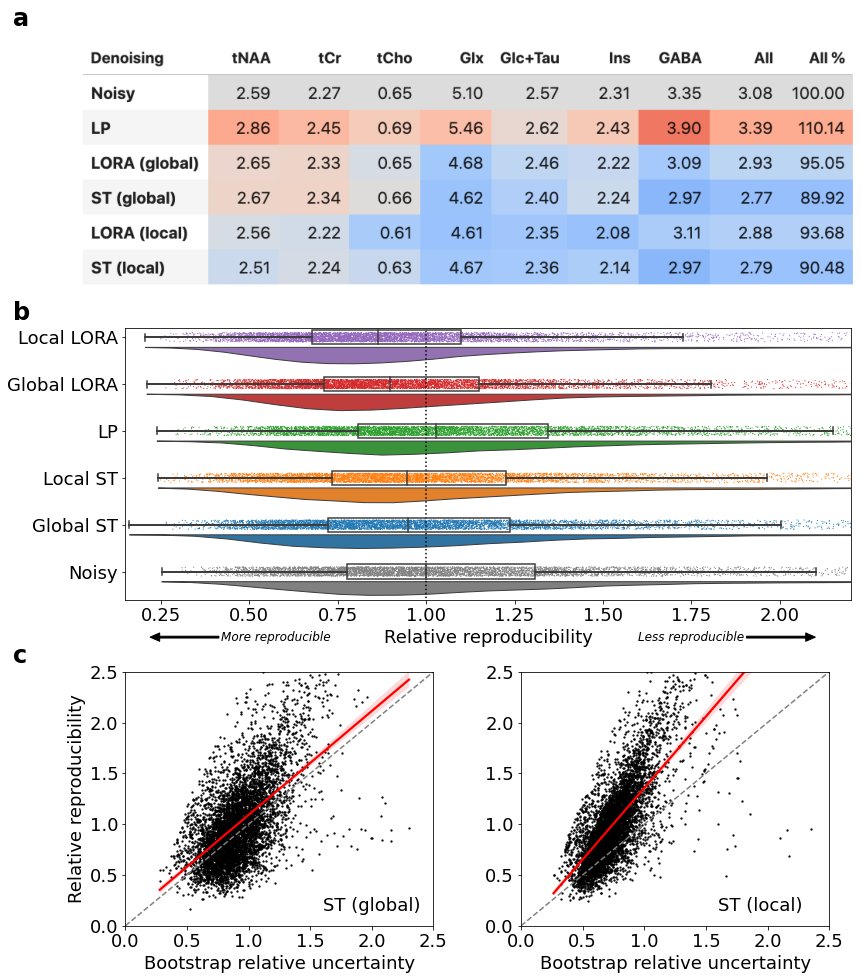

In [165]:
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=14)    # legend fontsize

# fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(13,15))
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(13,17))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, 0])
ax4 = plt.subplot(gs[2, 1])

img=plt.imread('figures/rmse_table.png')

metab_to_use = metab_all_large

cmap = plt.get_cmap("tab10")
colors_plot = [cmap(i) for i in range(len(labels)-1)]
colors_plot = [(0.5,0.5,0.5,1),] + colors_plot

# Panel 1 - table
ax1.imshow(img)
ax1.set_axis_off()
cpos = ax1.get_position()
scale = 1.07
ax1.set_position([0.075, 0.645, scale * cpos.width , scale * cpos.height])

# Panel 2 - Reproducibility
to_plot = df_repro_rel.loc[metab_to_use].reset_index().rename(columns={0:'value'})

dx = "method"; dy = "value"; ort = "h"; sigma = .1
ax2.vlines(1,-1,6,'k',linestyles=':')
pt.RainCloud(x = dx, y = dy,data = to_plot, order=method_order, palette = colors_plot, bw = sigma,
                 width_viol = .7, width_box=0.3, point_size=1.1, ax = ax2, orient = ort, box_showfliers=False)

ax2.set_xlim([0.15, 2.2])
ax2.set_ylim([-0.6, 5.2])
ax2.set_yticklabels(labels, rotation=0)
ax2.set_xlabel('Relative reproducibility')
ax2.set_ylabel('')

prop = dict(arrowstyle="simple,head_width=0.7,head_length=0.8,tail_width=0.15",
            shrinkA=0,shrinkB=0,
            color='black')
ax2.annotate("More reproducible", xy=(0.22,-1.4), xytext=(0.42,-1.4), arrowprops=prop, annotation_clip=False, va='center',
            fontsize=12, fontstyle='italic')
ax2.annotate("Less reproducible", xy=(2.1,-1.4), xytext=(1.9,-1.4), arrowprops=prop, annotation_clip=False, va='center',ha='right',
            fontsize=12, fontstyle='italic')

# Panel 3 - Comparison
g3_1 = sns.regplot(ax=ax3,
                 data=invivo_comp_df.xs('st_g',level='method').loc[metab_all_large],
                 x='bootstrap',y='rel_rep',
                 scatter_kws={'s':2,"color": "k"},
                 line_kws={"color": "red"})
ax3.set_xlim([0,2.5])
ax3.set_ylim([0,2.5])
ax3.set_xlabel('Bootstrap relative uncertainty')
ax3.set_ylabel('Relative reproducibility')
ax3.plot([0, 4],[0, 4],'--',color=(0.5,0.5,0.5))
ax3.text(1.6, 0.15, 'ST (global)')
cpos = ax3.get_position()
scale = 1/1.07
ax3.set_position([cpos.x0, cpos.y0, scale * cpos.width , scale * cpos.height])

g3_2 = sns.regplot(ax=ax4,
                 data=invivo_comp_df.xs('st_l',level='method').loc[metab_all_large],
                 x='bootstrap',y='rel_rep',
                 scatter_kws={'s':2,"color": "k"},
                 line_kws={"color": "red"})
ax4.set_xlim([0,2.5])
ax4.set_ylim([0,2.5])
ax4.set_xlabel('Bootstrap relative uncertainty')
ax4.set_ylabel('')
ax4.plot([0, 4],[0, 4],'--',color=(0.5,0.5,0.5))
ax4.text(1.6, 0.15, 'ST (local)')
cpos = ax4.get_position()
scale = 1/1.07
ax4.set_position([cpos.x0, cpos.y0, scale * cpos.width , scale * cpos.height])


fig.text(0.005, 0.86,'a',fontweight='bold',fontsize=24)
fig.text(0.005, 0.62,'b',fontweight='bold',fontsize=24)
fig.text(0.005, 0.34,'c',fontweight='bold',fontsize=24)


plt.savefig('figures/figure_9_in_vivo_combined.png', bbox_inches='tight', dpi=300)